# Predicción de Cancelación de Clientes (Churn)

## Contexto
El objetivo de este proyecto es predecir la cancelación de clientes de una empresa de telecomunicaciones a partir de datos históricos de comportamiento, servicios contratados y características del cliente.

## Objetivo
Construir y evaluar modelos de clasificación que permitan identificar clientes con alta probabilidad de cancelar el servicio, utilizando métricas apropiadas para problemas de clasificación desbalanceados.

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

## Carga de datos

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

## Limpieza de datos

### Datos de contrato

#### Mostrar información general sobre el dataset de contrato

In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [6]:
contract.shape

(7043, 8)

#### Limpiar datos

In [7]:
# creamos una función para convertir nombres de columnas a snake_case
def to_snake_case(col_name):
    # Separar palabras unidas por mayúsculas
    col_name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', col_name)
    # Manejar siglas o mayúsculas seguidas
    col_name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', col_name)
    return col_name.lower()

# creamos una función para limpiar un DataFrame completo
def clean_dataframe(df):
    # Convertir nombres de columnas
    df = df.rename(columns=lambda x : to_snake_case(x))
    # Limpiar espacios no deseados en las columnas tipo object
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].str.strip()
    return df

In [8]:
# Limpiamos el dataframe
contract = clean_dataframe(contract)

# corregimos los tipos de datos
    # begin_date y end_date deben ser datetime
contract['begin_date'] = pd.to_datetime(contract['begin_date'], errors='coerce')
contract['end_date'] = pd.to_datetime(contract['end_date'], errors='coerce')
    # TotalCharges debe ser float64
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')
# revisamos valores ausentes
print('Valores ausentes', contract.isna().sum())
# revisamos filas duplicadas
print('Filas duplicadas', contract.duplicated().sum())

Valores ausentes customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
dtype: int64
Filas duplicadas 0


#### Verificamos

In [9]:
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [10]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


**Observación:** Después de corregir los tipos de datos aparecieron valores ausentes en las columnas 'end_date' y 'total_charges', más adelante analizaremos a profundidad el significado de esto.

### Datos personales

#### Mostrar información general sobre el dataset de datos personales

In [11]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [12]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [13]:
personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [14]:
personal.shape

(7043, 5)

#### Limpiar datos

In [15]:
# Limpiamos el dataframe
personal = clean_dataframe(personal)

# revisamos valores ausentes
print('Valores ausentes:\n', personal.isna().sum())
# revisamos filas duplicadas
print('\nFilas duplicadas:\n', personal.duplicated().sum())

Valores ausentes:
 customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

Filas duplicadas:
 0


#### Verificamos

In [16]:
personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [17]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


### Plan de internet

#### Mostrar información general sobre el dataset del plan de internet

In [18]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [19]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [20]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,6481-ESCNL,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [21]:
internet.shape

(5517, 8)

#### Limpiar datos

In [22]:
# Limpiamos el dataframe
internet = clean_dataframe(internet)

# revisamos valores ausentes
print('Valores ausentes:\n', internet.isna().sum())
# revisamos filas duplicadas
print('\nFilas duplicadas:\n', internet.duplicated().sum())

Valores ausentes:
 customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

Filas duplicadas:
 0


#### Verificamos

In [23]:
internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [24]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


### Plan telefónico

#### Mostrar información general sobre el dataset del plan telefónico

In [25]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [26]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [27]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5451-MHQOF,No
freq,1,3390


In [28]:
phone.shape

(6361, 2)

#### Limpiar datos

In [29]:
# Limpiamos el dataframe
phone = clean_dataframe(phone)

# revisamos valores ausentes
print('Valores ausentes:\n', phone.isna().sum())
# revisamos filas duplicadas
print('\nFilas duplicadas:\n', phone.duplicated().sum())

Valores ausentes:
 customer_id       0
multiple_lines    0
dtype: int64

Filas duplicadas:
 0


#### Verificamos

In [30]:
phone.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [31]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


## Análisis exploratorio de datos

### Unión de datasets

In [32]:
# Unificamos las cuatro tablas de datos para poder hacer el análisis exploratorio
df_merged = contract.merge(personal, on='customer_id', how='left')
df_merged = df_merged.merge(internet, on='customer_id', how='left')
full_data = df_merged.merge(phone, on='customer_id', how='left')

In [33]:
# Verificamos que se hayan conservado correctamente todos los clientes después del merge
print(full_data.shape)
print()
print(full_data['customer_id'].nunique())

(7043, 20)

7043


### Mostrar información general sobre el dataset final

In [34]:
full_data.head(50)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,NaT,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,NaT,Month-to-month,No,Mailed check,29.75,301.90,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,NaT,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


In [35]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [36]:
full_data.isna().sum()

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

**Observaciones:**

Existen 5174 valores ausentes en 'end_date', lo que significa que 5174 clientes aún tienen su contrato activo.

Existen 1526 filas con valores ausentes en las columnas correspondientes al dataset internet, lo que significa que 1526 clientes no cuentan con el servicio de internet.

Existen 682 filas con valores ausentes en la columna correspondiente al dataset phone, lo que significa que 682 clientes no cuentan con el servicio de telefonía.

Lo anterior también nos indica que existen 2,208 clientes que poseen un solo servicio, y 4,835 clientes con ambos servicios contratados.

In [37]:
# Analizamos los clientes que tienen valores ausentes en 'total_charges'
full_data[full_data['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


**Observación:**

Las filas con valores ausentes en 'total_charges' se refieren a clientes que acaban de iniciar su contrato, por lo que aún no han acumulado ningún cargo total.

### Tratar valores ausentes

In [38]:
# Reemplazamos con 'No' los valores ausentes en las columnas correspondientes al dataset de internet
internet_cols = ['internet_service', 'online_security', 'online_backup',
                 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

for col in internet_cols:
    full_data[col] = full_data[col].fillna('No')

In [39]:
# Verificamos
print(full_data[internet_cols].isna().sum())

internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64


In [40]:
# Reemplazamos con 'No' los valores ausentes en la columna correspondiente al dataset de telefonía
full_data['multiple_lines'] = full_data['multiple_lines'].fillna('No')

In [41]:
# Verificamos
print(full_data['multiple_lines'].isna().sum())

0


In [42]:
# Reemplazamos con 0 los valores ausentes en la columna 'total_charges'
full_data['total_charges'] = full_data['total_charges'].fillna(0)

In [43]:
# Verificamos
print(full_data['total_charges'].isna().sum())

0


In [44]:
full_data.head(30)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,NaT,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,NaT,Month-to-month,No,Mailed check,29.75,301.90,Female,0,No,No,DSL,Yes,No,No,No,No,No,No
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,NaT,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


In [45]:
full_data.isna().sum()

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
multiple_lines          0
dtype: int64

### Enriquecer datos

In [46]:
# Agregar una variable que indique si el cliente canceló su contrato (esta será nuestra nueva variable objetivo)
full_data['churn'] = full_data['end_date'].notna().astype(int)

# Agregar una variable para indicar la antigüedad del cliente
reference_date = full_data['end_date'].max() # Usamos como referencia la última fecha observada en el dataset para evitar data leakage temporal
full_data['end_date_filled'] = full_data['end_date'].fillna(reference_date)
full_data['tenure'] = (
    (full_data['end_date_filled'] - full_data['begin_date']).dt.days / 30
).round()

# Agregar una variable que indique si el cliente cuenta con el servivio de internet
full_data['has_internet'] = (full_data['internet_service'] != 'No').astype(int)

# Agregar una variable que indique si el cliente cuenta con el servicio de telefonía
full_data['has_phone'] = (full_data['multiple_lines'] != 'No').astype(int)

# Agregar una variable que indique si el cliente cuenta con un solo servicio
full_data['one_service'] = (full_data['has_internet'] + full_data['has_phone'] == 1).astype(int)

# Agregar el mes (por nombre y número) de inicio y fin de contrato
full_data['begin_month'] = full_data['begin_date'].dt.month
full_data['begin_month_name'] = full_data['begin_date'].dt.month_name()
full_data['churn_month'] = full_data['end_date'].dt.month
full_data['churn_month_name'] = full_data['end_date'].dt.month_name()

In [47]:
full_data.head(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,churn,end_date_filled,tenure,has_internet,has_phone,one_service,begin_month,begin_month_name,churn_month,churn_month_name
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,0,2020-01-01,0.0,1,0,1,1,January,NaN,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,...,0,2020-01-01,34.0,1,0,1,4,April,NaN,NaN
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,1,2019-12-01,2.0,1,0,1,10,October,12.0,December
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,0,2020-01-01,45.0,1,0,1,5,May,NaN,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,1,2019-11-01,2.0,1,0,1,9,September,11.0,November
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,...,1,2019-11-01,8.0,1,1,0,3,March,11.0,November
6,1452-KIOVK,2018-04-01,NaT,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Male,0,...,0,2020-01-01,21.0,1,1,0,4,April,NaN,NaN
7,6713-OKOMC,2019-04-01,NaT,Month-to-month,No,Mailed check,29.75,301.90,Female,0,...,0,2020-01-01,9.0,1,0,1,4,April,NaN,NaN
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,...,1,2019-11-01,28.0,1,1,0,7,July,11.0,November
9,6388-TABGU,2014-12-01,NaT,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,...,0,2020-01-01,62.0,1,0,1,12,December,NaN,NaN


In [48]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

In [49]:
full_data.isna().sum()

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
multiple_lines          0
churn                   0
end_date_filled         0
tenure                  0
has_internet            0
has_phone               0
one_service             0
begin_month             0
begin_month_name        0
churn_month          5174
churn_month_name     5174
dtype: int64

In [50]:
full_data.describe()

,monthly_charges,total_charges,senior_citizen,churn,tenure,has_internet,has_phone,one_service,begin_month,churn_month
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,1869.000000
mean,64.761692,2279.734304,0.162147,0.265370,32.075394,0.783331,0.421837,0.458611,6.421269,8.543071
std,30.090047,2266.794470,0.368612,0.441561,24.851147,0.412004,0.493888,0.498319,3.578453,4.368087
min,18.250000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,35.500000,398.550000,0.000000,0.000000,8.000000,1.000000,0.000000,0.000000,3.000000,10.000000
50%,70.350000,1394.550000,0.000000,0.000000,28.000000,1.000000,0.000000,0.000000,6.000000,11.000000
75%,89.850000,3786.600000,0.000000,1.000000,56.000000,1.000000,1.000000,1.000000,10.000000,11.000000
max,118.750000,8684.800000,1.000000,1.000000,73.000000,1.000000,1.000000,1.000000,12.000000,12.000000


### Análisis general

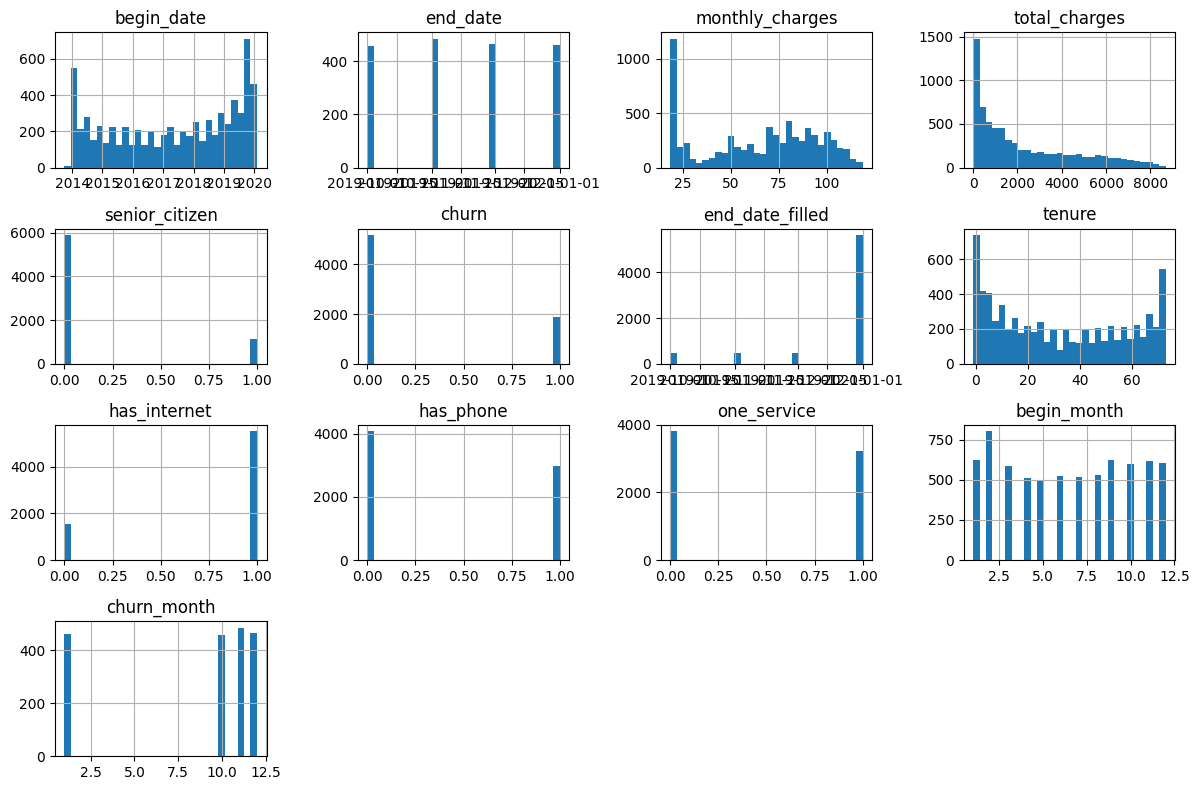

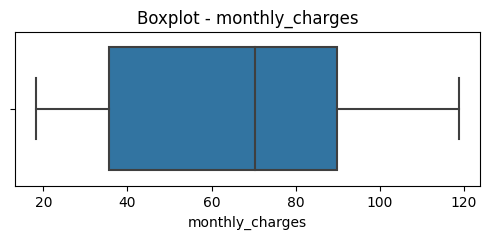

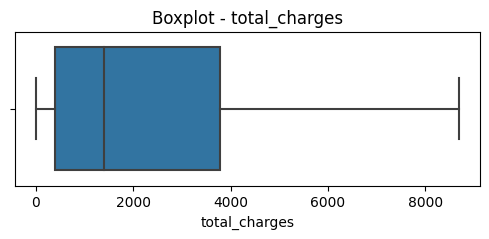

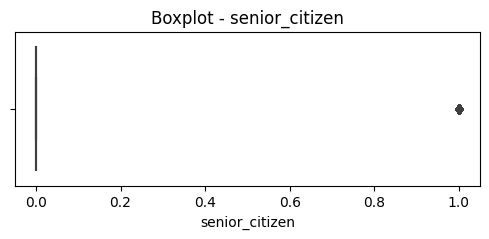

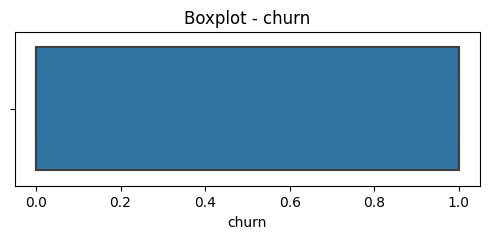

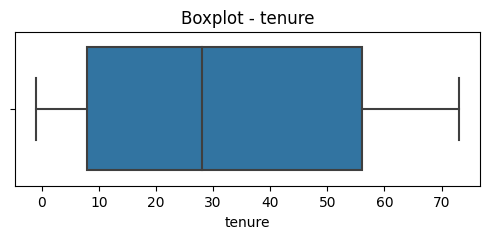

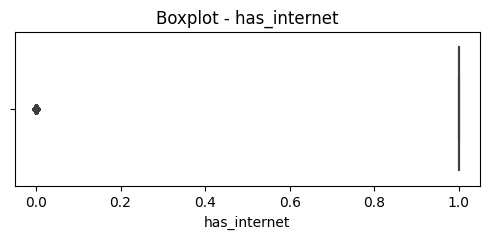

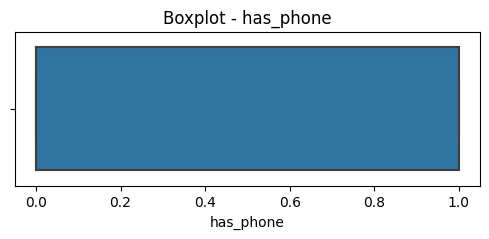

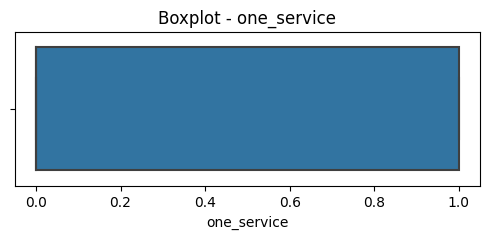

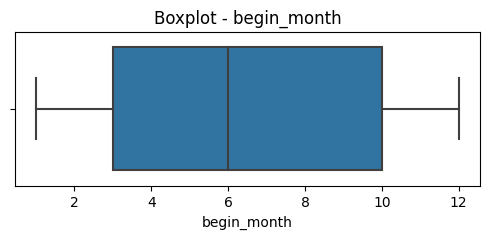

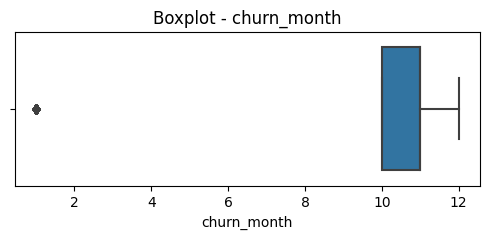


Distribución de customer_id:
5451-MHQOF    1
7395-XWZOY    1
1544-JJMYL    1
5740-YHGTW    1
2351-RRBUE    1
             ..
1020-JPQOW    1
6878-GGDWG    1
4598-XLKNJ    1
6784-XYJAE    1
4472-VESGY    1
Name: customer_id, Length: 7043, dtype: int64

Distribución de type:
Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

Distribución de paperless_billing:
Yes    4171
No     2872
Name: paperless_billing, dtype: int64

Distribución de payment_method:
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

Distribución de gender:
Male      3555
Female    3488
Name: gender, dtype: int64

Distribución de partner:
No     3641
Yes    3402
Name: partner, dtype: int64

Distribución de dependents:
No     4933
Yes    2110
Name: dependents, dtype: int64

Distribución de internet_service:
Fiber optic    3096
DSL            2421
No        

In [51]:
# ANÁLISIS GENERAL
# Creamos un histograma para cada variable numérica
full_data.hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()

# Creamos un boxplot para cada variable numérica (sin target)
for col in full_data.select_dtypes(include='number'):
    plt.figure(figsize=(6,2))
    sns.boxplot(x=full_data[col])
    plt.title(f'Boxplot - {col}')
    plt.show()

# Observamos la distribución de categorías en cada columna categórica
for col in full_data.select_dtypes(include='object'):
    print(f"\nDistribución de {col}:")
    print(full_data[col].value_counts(dropna=False))

**Observaciones:**

Todas las variables numéricas muestran variabilidad suficiente, rangos adecuados y distribuciones coherentes en los histogramas y diagramas de caja. Ninguna presenta valores atípicos imposibles ni concentraciones extremas. Por lo tanto, todas son apropiadas para el análisis específico segmentado por el target.

En cuanto a las variables categóricas, tras revisar las distribuciones con value_counts(), todas las variables presentaron variedad suficiente en sus categorías como para incluirlas en el análisis específico segmentado por el target. La única excepción es customer_id, ya que es un identificador único y no aporta información útil, por lo que se descartará.

In [52]:
# Filtrar columnas relevantes para análisis específico

# Columnas que representan meses pero deben tratarse como categóricas
meses_numericos = ['begin_month', 'churn_month']

# Detectar columnas binarias numéricas (deben tratarse como categóricas)
binarias_numericas = [
    col for col in full_data.select_dtypes(include=['number']).columns
    if full_data[col].nunique() == 2 and col != 'churn'
]

# Numéricas
numericas_relevantes = [
    col for col in full_data.select_dtypes(include=['number']).columns
    if col not in ['churn'] + binarias_numericas + meses_numericos
]

# Categóricas
categoricas_relevantes = [
    col for col in full_data.select_dtypes(include=['object']).columns
    if col not in ['customer_id']
] + binarias_numericas

# Orden natural de meses por nombre
orden_meses_nombre = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

In [53]:
# Observamos el balanceo de clases en la variable objetivo
print(full_data['churn'].value_counts(normalize=True))

0    0.73463
1    0.26537
Name: churn, dtype: float64


### Análisis específico

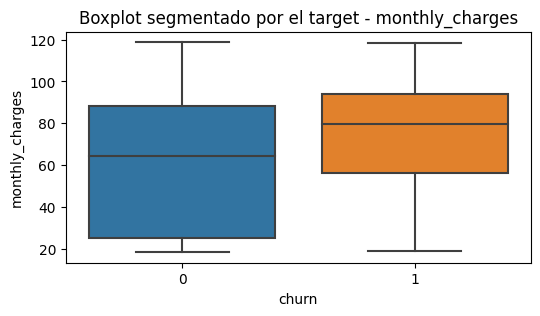

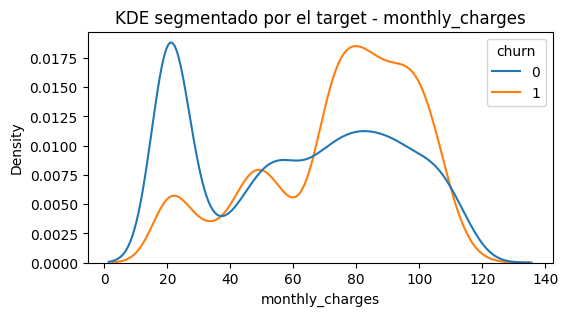


Valor medio de monthly_charges según el target:
churn
0    61.265124
1    74.441332
Name: monthly_charges, dtype: float64


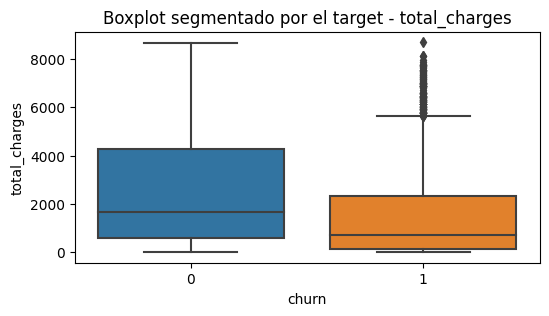

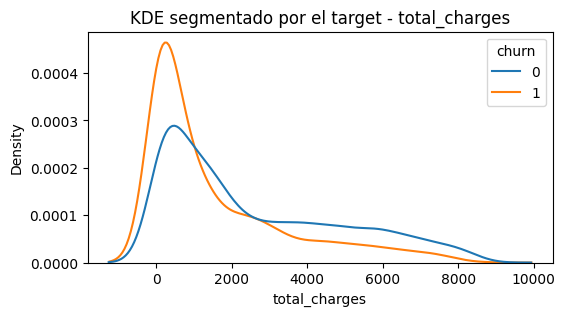


Valor medio de total_charges según el target:
churn
0    2549.911442
1    1531.796094
Name: total_charges, dtype: float64


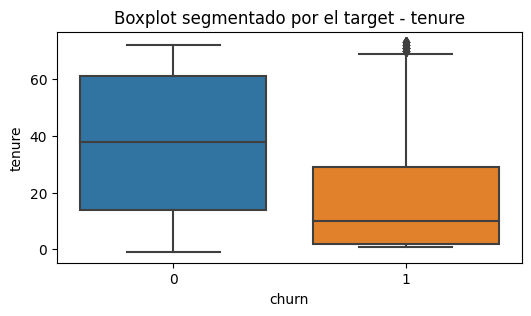

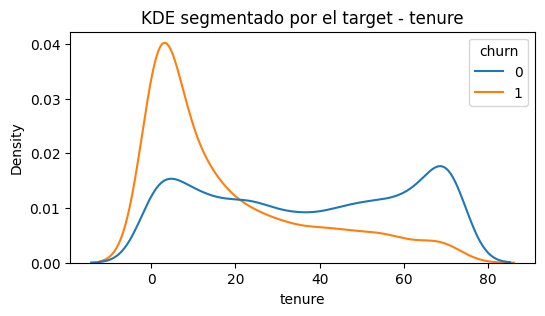


Valor medio de tenure según el target:
churn
0    37.095477
1    18.178170
Name: tenure, dtype: float64


In [54]:
# ANÁLISIS ESPECÍFICO PARA VARIABLES NUMÉRICAS
for col in numericas_relevantes:

    # Creamos un boxplot segmentado por la variable objetivo
    plt.figure(figsize=(6,3))
    sns.boxplot(x='churn', y=col, data=full_data)
    plt.title(f'Boxplot segmentado por el target - {col}')
    plt.show()

    if (full_data[col].nunique() > 10):
        # Creamos un KDE segmentado por la variable objetivo solo para variables continuas
        plt.figure(figsize=(6,3))
        sns.kdeplot(data=full_data, x=col, hue='churn', common_norm=False)
        plt.title(f'KDE segmentado por el target - {col}')
        plt.show()

    # Mostramos el valor medio de la columna según el target
    print(f"\nValor medio de {col} según el target:")
    print(full_data.groupby('churn')[col].mean())

**Observaciones:**

**Relación de los cargos mensuales con la cancelación del servicio:**

Los clientes que cancelaron presentan cargos mensuales considerablemente más altos. El boxplot muestra que no hay valores anormales. El KDE confirma que los clientes activos se concentran en pagos entre 20 y 40 USD, mientras que quienes cancelaron se concentran principalmente entre 60 y 100 USD. Además, la media de pago mensual también es mayor en el grupo que se dio de baja (74 USD) en comparación con el grupo activo (61 USD). Esto sugiere que los clientes con tarifas más elevadas son más propensos a cancelar su contrato.

**Relación de los cargos totales con la cancelación del servicio:**

Los valores atípicos mostrados en el boxplot sugieren que solo una pequeña parte de los clientes que cancelaron su contrato llegaron a pagar más de 6000 USD totales.
El KDE muestra que los clientes activos se concentran principalmente entre los 0 y 2500 USD totales, mientras que los que cancelaron se concentran entre los 0 y 1500 USD. 
Además, la media del pago total es mayor en el grupo que sigue activo (2549 USD) en comparación con el grupo que canceló su contrato (1531 USD).
Esto tiene sentido ya que los clientes con contrato activo siguen acumulando cargos mientras que a los que ya cancelaron se les deja de cobrar.
Con esto podemos concluir que la cancelación del servicio no se ve influenciada por los cargos totales, sino que los cargos totales reflejan la antigüedad.

**Relación de la antigüedad con la cancelación del servicio:**

Los valores atípicos en el boxplot sugieren que solo una pequeña parte de los clientes que cancelaron su servicio llevaba más de 70 meses de antigüedad.
En el KDE los clientes activos muestran una distribución bastante uniforme entre los 0 y 80 meses de antigüedad, lo que indica una gran estabilidad. Por otro lado, los clientes que cancelaron se concentran mayormente entre los 0 y 20 meses.
El valor medio de antigüedad es claramente mayor en los clientes activos (37 meses), en comparación con los clientes que cancelaron (18 meses).
Todo lo anterior sugiere que existe una gran probabilidad de cancelación con clientes relativamente nuevos, mientras que con clientes antiguos la probabilidad es muy escasa.

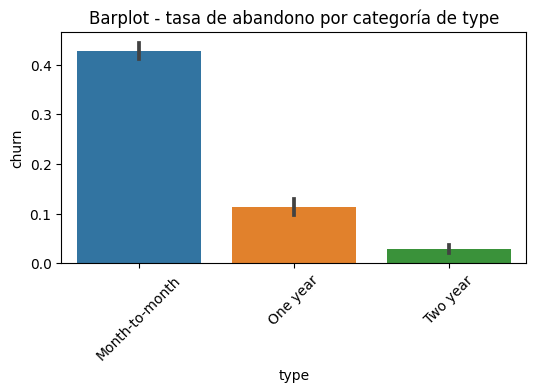


Tasa de abandono según type:
type
Month-to-month    0.427097
One year          0.112695
Two year          0.028319
Name: churn, dtype: float64


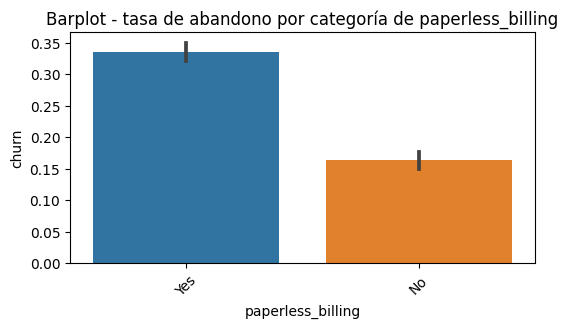


Tasa de abandono según paperless_billing:
paperless_billing
No     0.163301
Yes    0.335651
Name: churn, dtype: float64


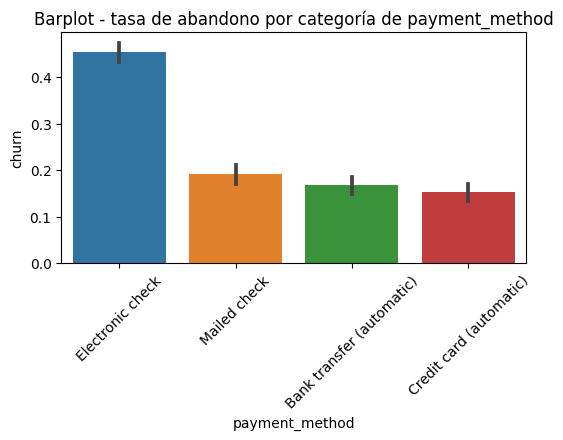


Tasa de abandono según payment_method:
payment_method
Bank transfer (automatic)    0.167098
Credit card (automatic)      0.152431
Electronic check             0.452854
Mailed check                 0.191067
Name: churn, dtype: float64


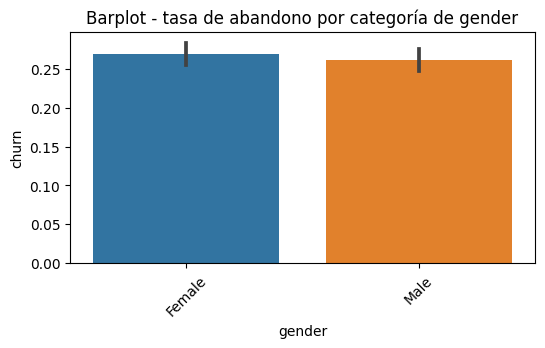


Tasa de abandono según gender:
gender
Female    0.269209
Male      0.261603
Name: churn, dtype: float64


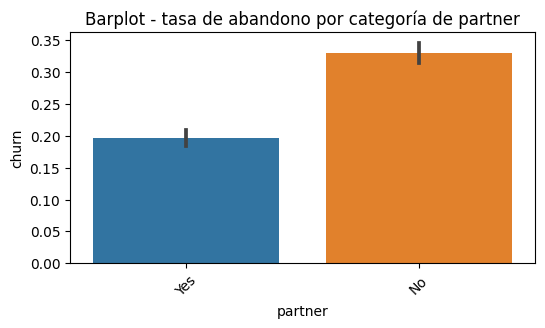


Tasa de abandono según partner:
partner
No     0.329580
Yes    0.196649
Name: churn, dtype: float64


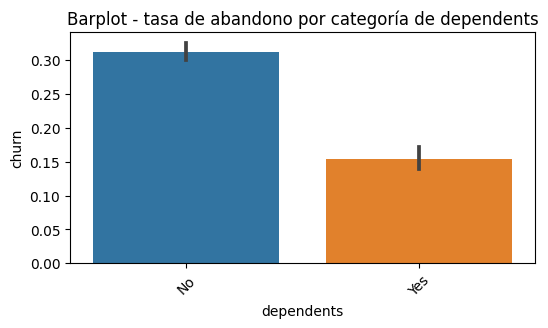


Tasa de abandono según dependents:
dependents
No     0.312791
Yes    0.154502
Name: churn, dtype: float64


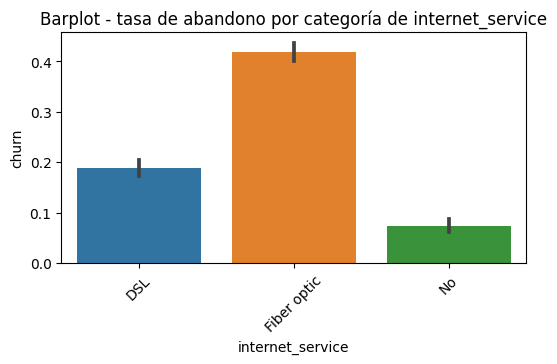


Tasa de abandono según internet_service:
internet_service
DSL            0.189591
Fiber optic    0.418928
No             0.074050
Name: churn, dtype: float64


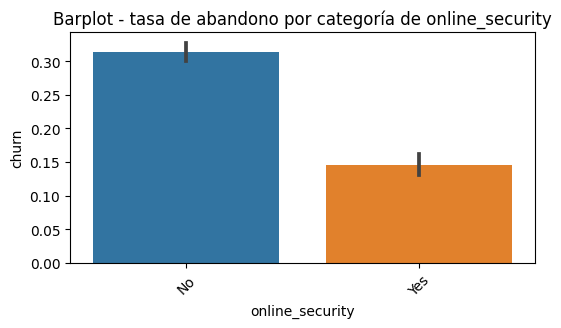


Tasa de abandono según online_security:
online_security
No     0.313296
Yes    0.146112
Name: churn, dtype: float64


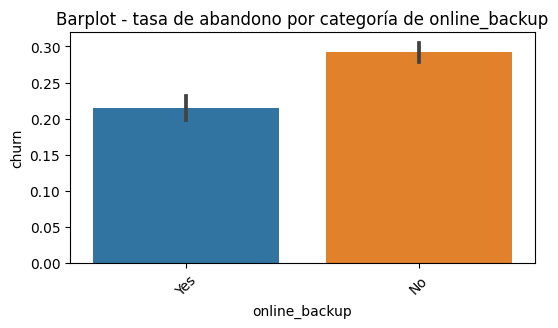


Tasa de abandono según online_backup:
online_backup
No     0.291721
Yes    0.215315
Name: churn, dtype: float64


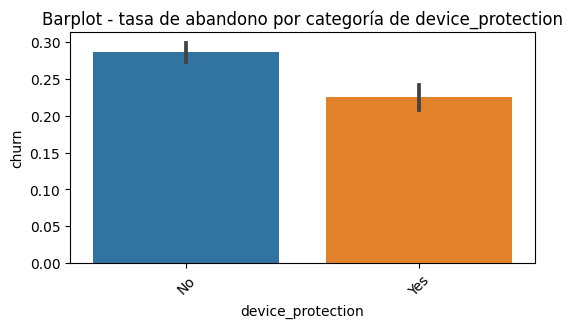


Tasa de abandono según device_protection:
device_protection
No     0.286518
Yes    0.225021
Name: churn, dtype: float64


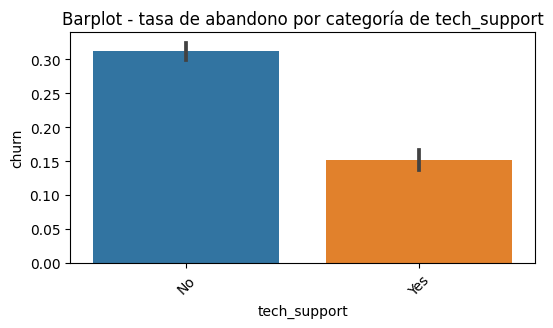


Tasa de abandono según tech_support:
tech_support
No     0.311862
Yes    0.151663
Name: churn, dtype: float64


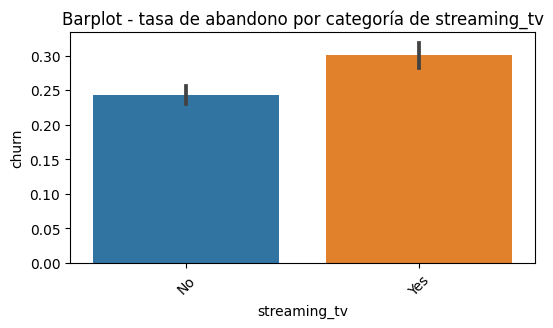


Tasa de abandono según streaming_tv:
streaming_tv
No     0.243312
Yes    0.300702
Name: churn, dtype: float64


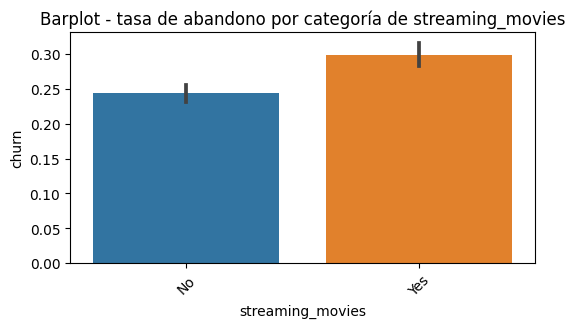


Tasa de abandono según streaming_movies:
streaming_movies
No     0.243795
Yes    0.299414
Name: churn, dtype: float64


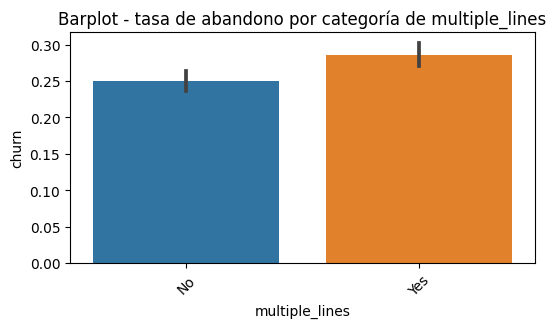


Tasa de abandono según multiple_lines:
multiple_lines
No     0.250246
Yes    0.286099
Name: churn, dtype: float64


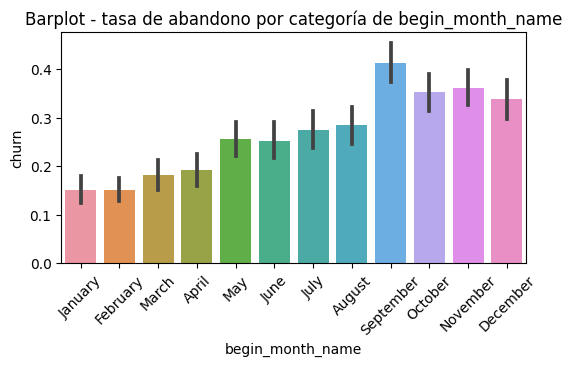


Tasa de abandono según begin_month_name:
begin_month_name
April        0.191781
August       0.283835
December     0.337748
February     0.151741
January      0.150883
July         0.274131
June         0.252874
March        0.181356
May          0.255061
November     0.360709
October      0.352745
September    0.412520
Name: churn, dtype: float64


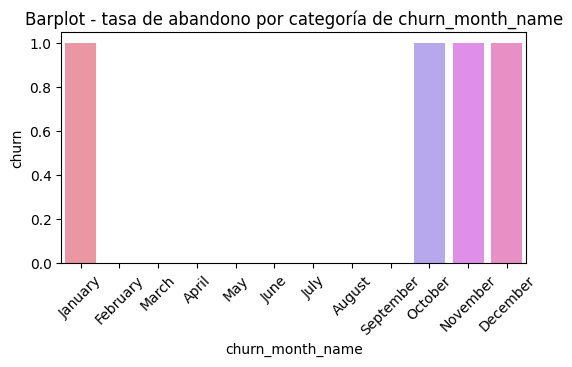


Tasa de abandono según churn_month_name:
churn_month_name
December    1
January     1
November    1
October     1
Name: churn, dtype: int64


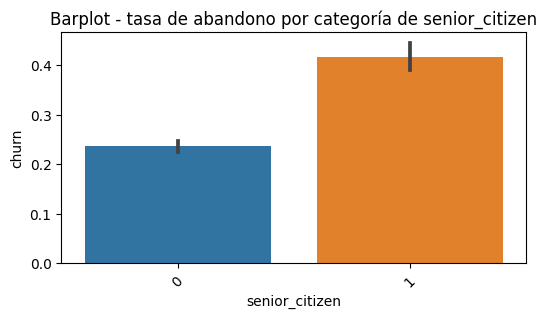


Tasa de abandono según senior_citizen:
senior_citizen
0    0.236062
1    0.416813
Name: churn, dtype: float64


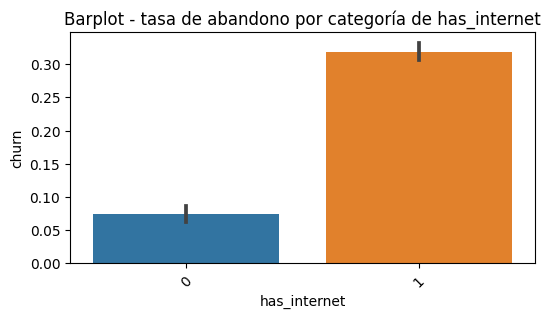


Tasa de abandono según has_internet:
has_internet
0    0.074050
1    0.318289
Name: churn, dtype: float64


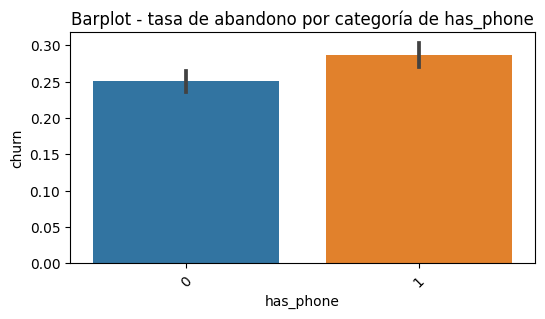


Tasa de abandono según has_phone:
has_phone
0    0.250246
1    0.286099
Name: churn, dtype: float64


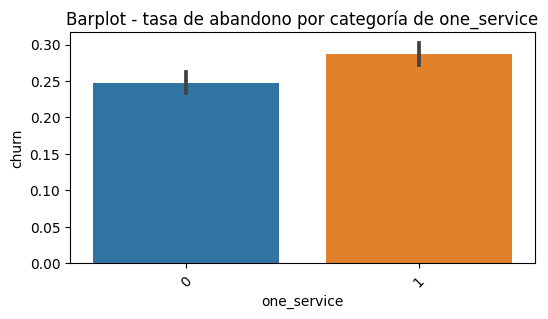


Tasa de abandono según one_service:
one_service
0    0.247312
1    0.286687
Name: churn, dtype: float64


In [55]:
# ANÁLISIS ESPECÍFICO PARA VARIABLES CATEGÓRICAS
for col in categoricas_relevantes:
    
    plt.figure(figsize=(6,3))
    # ordenar correctamente si la columna es de nombre de mes
    if col in ['begin_month_name', 'churn_month_name']:
        sns.barplot(x=col, y='churn', data=full_data, order=orden_meses_nombre)
    else:
        sns.barplot(x=col, y='churn', data=full_data)

    plt.xticks(rotation=45)
    plt.title(f'Barplot - tasa de abandono por categoría de {col}')
    plt.show()

    # Mostramos el valor medio de abandono por categoría
    print(f"\nTasa de abandono según {col}:")
    print(full_data.groupby(col)['churn'].mean())

**Observaciones:**

**Relación del tipo de contrato con la cancelación del servicio:**

La tasa de abandono varía de manera significativa según el tipo de contrato.
Los clientes con contratos mensuales presentan la tasa de cancelación más alta (42%), mientras que quienes tienen contratos anuales y bienales muestran tasas mucho menores (11% y 2%, respectivamente). Esto podría deberse a que los contratos mensuales implican menos compromiso y permiten cancelar fácilmente, lo que los hace mucho más propensos a la deserción. En cambio, los contratos anuales y bienales suelen incluir beneficios, descuentos o penalizaciones por cancelación, lo que reduce drásticamente la probabilidad de cancelación.

**Relación del tipo de facturación con la cancelación del servicio:**

La tasa de abandono para clientes con facturación electrónica (33%) es más del doble que la de clientes con facturación en papel (16%). Esto sugiere que quienes usan facturación electrónica tienden a cancelar con mayor frecuencia. Una explicación podría ser que este grupo de clientes suele ser más digital, mientras que los que utilizan facturación en papel podrían carecer de conocimiento tecnológico.

**Relación del método de pago con la cancelación del servicio:**

Los clientes que usan cheque electrónico presentan la tasa de cancelación más alta (45%), mientras que quienes utilizan cheques por correo, transferencia bancaria y tarjeta de crédito muestran tasas mucho menores y muy similares entre ellas (19%, 16% y 15%, respectivamente).
Esto sugiere que existe una mayor probabilidad de cancelación entre los clientes que usan cheque electrónico. En cambio, los métodos automáticos y el pago por correo tienden a estar más asociados con clientes que permanecen activos.

**Relación del género del cliente con la cancelación del servicio:**

La tasa de cancelación es prácticamente igual entre hombres y mujeres (26.9% y 26.1%, respectivamente). Esta mínima diferencia no sugiere ningún patrón relevante, por lo que el género del cliente no parece influir en la probabilidad de cancelación del servicio.

**Relación del estado de convivencia con la cancelación del servicio:**

La tasa de abandono es más baja entre los clientes que viven con una pareja o compañero de hogar (19%) en comparación con quienes viven solos (32%). Esto sugiere que los clientes sin compañía son más propensos a cancelar su servicio. Una posible razón es que los hogares con más de una persona suelen compartir el servicio y dividir el costo, mientras que para quienes viven solos el gasto puede resultar más significativo.

**Relación de los dependientes con la cancelación del servicio:**

La tasa de abandono es considerablemente mayor entre los clientes que no tienen dependientes (31%) en comparación con quienes sí cuentan con ellos (15%). Esto sugiere que los clientes sin dependientes tienden a cancelar con más frecuencia, posiblemente porque no tienen otros miembros del hogar que dependan del servicio, lo que reduce su nivel de compromiso con mantenerlo activo.

**Relación del tipo de servicio de internet con la cancelación del servicio:**

La tasa de abandono es considerablemente mayor entre los clientes que cuentan con fibra óptica (41%), en comparación con quienes utilizan DSL (18%) o quienes no poseen servicio de internet (7%). Esto indica una fuerte asociación entre el uso de fibra óptica y una mayor probabilidad de cancelación, por lo que los clientes con este tipo de servicio resultan claramente más propensos a darse de baja.

**Relación de la seguridad online con la cancelación del servicio:**

La tasa de abandono es considerablemente mayor entre los clientes que no cuentan con seguridad online (31%) en comparación con quienes sí la tienen (14%). Esto sugiere que los usuarios sin este servicio adicional presentan una mayor tendencia a cancelar su contrato.

**Relación de la copia de seguridad en la nube con la cancelación del servicio:**

La tasa de cancelación es ligeramente mayor entre los clientes que no cuentan con copia de seguridad en la nube (29%), en comparación con quienes sí la tienen (21%). Esto sugiere que los usuarios sin este servicio adicional presentan una tendencia ligeramente mayor a cancelar su contrato.

**Relación de la protección de dispositivo con la cancelación del servicio:**

La tasa de cancelación es ligeramente mayor entre los clientes que no cuentan con protección de dispositivo (28%) en comparación con quienes sí la tienen (22%). Esto sugiere que los usuarios sin este servicio adicional presentan una tendencia un poco mayor a cancelar su contrato.

**Relación del soporte técnico con la cancelación del servicio:**

La tasa de abandono es considerablemente mayor entre los clientes que no cuentan con soporte técnico (31%) en comparación con quienes sí lo tienen (15%). Esto sugiere que los usuarios sin este servicio adicional presentan una mayor tendencia a cancelar su contrato.

**Relación del streaming de TV con la cancelación del servicio:**

La tasa de abandono es ligeramente mayor entre los clientes que cuentan con streaming de TV (30%) en comparación con los que no lo tienen (24%). Esto sugiere que los usuarios que cuentan con este servicio presentan una ligera mayor tendencia a cancelar su contrato.

**Relación del streaming de películas con la cancelación del servicio:**

La tasa de abandono es ligeramente mayor entre los clientes que cuentan con streaming de películas (29%) en comparación con quienes no lo tienen (24%). Esto sugiere que los usuarios que tienen este servicio adicional presentan una ligera tendencia mayor a cancelar su contrato.

**Relación de la cantidad de líneas con la cancelación del servicio:**

La tasa de cancelación para los clientes que cuentan con múltiples líneas y los que no son muy similares entre sí (28% y 25%, respectivamente). Esta mínima diferencia no sugiere ningún patrón relevante, por lo que la cantidad de líneas no parece influir en la probabilidad de cancelación del servicio.

**Relación del mes de inicio del contrato con la cancelación del servicio:**

La tasa de abandono presenta variaciones importantes según el mes de inicio del contrato, con valores bajos a comienzos del año y un aumento progresivo hacia los últimos meses. Si bien el patrón es claro, los datos disponibles no permiten determinar la causa detrás de estas diferencias.

**Relación del mes de cancelación con la tasa de abandono:**

El mes de cancelación siempre presenta una tasa de abandono igual a 1, porque solo incluye casos donde el cliente abandonó. Por ello, esta variable no aporta información útil para el análisis de la cancelación.

**Relación de la edad avanzada con la cancelación del servicio:**

La tasa de abandono es considerablemente mayor entre los clientes de edad avanzada (41%) en comparación con quienes no lo son (23%). Esto indica que los adultos mayores muestran una mayor probabilidad de cancelar su contrato.

**Relación de la tenencia del servicio de internet con la cancelación del servicio:**

La tasa de cancelación es significativamente mayor entre los clientes que cuentan con servicio de internet (31%) en comparación con quienes no lo tienen (7%). Esto indica que los usuarios con servicio de internet presentan una probabilidad de cancelación mucho más alta que aquellos sin este servicio.

**Relación de la tenencia del servicio telefónico con la cancelación del servicio:**

La tasa de cancelación para los clientes que cuentan con servicio telefónico y para los que no lo tienen es bastante similar (28% y 25%, respectivamente). Esta diferencia mínima no sugiere ningún patrón relevante, por lo que el hecho de disponer o no del servicio telefónico no parece influir en la probabilidad de cancelación del contrato.

**Relación de la tenencia de un solo servicio con la cancelación del contrato:**

La tasa de abandono entre los clientes que cuentan con un solo servicio (29%) y quienes tienen ambos (25%) es muy similar. Esta diferencia mínima no revela un patrón significativo, por lo que el hecho de poseer uno o ambos servicios no parece influir de manera relevante en la probabilidad de cancelación.

### Conclusión del EDA

El análisis exploratorio revela que la cancelación del servicio está asociada principalmente con tres dimensiones: el tipo de contrato del cliente, su antigüedad, y las características de los servicios que tiene contratados.

En primer lugar, las variables relacionadas con el nivel de compromiso y la situación del hogar muestran patrones muy marcados: los clientes con contratos mensuales, que viven solos o que no tienen dependientes presentan tasas de abandono considerablemente más altas, mientras que quienes viven acompañados o tienen personas a su cargo tienden a mantener el servicio por más tiempo.

En segundo lugar, la antigüedad del cliente (tenure) es uno de los factores más determinantes. La mayoría de las cancelaciones proviene de clientes relativamente nuevos, mientras que aquellos con muchos meses de permanencia casi no desertan. Esto indica que la retención temprana es clave: si un cliente supera los primeros meses, es mucho más probable que continúe usando el servicio.

En cuanto a los servicios contratados, ciertos complementos como seguridad online, soporte técnico, copias de seguridad y protección de dispositivo están asociados con menores tasas de cancelación, lo que sugiere que los clientes que contratan servicios adicionales tienden a mantenerse activos por más tiempo. Por el contrario, los usuarios con fibra óptica y quienes utilizan métodos de pago como el cheque electrónico muestran una probabilidad significativamente mayor de cancelar.

Finalmente, algunas variables como el género, cantidad de líneas telefónicas o tener uno vs. dos servicios, no muestran relación relevante con la cancelación de contrato. El mes de cancelación tampoco aporta información útil, mientras que el mes de inicio presenta variaciones claras pero sin una causa identificable con los datos disponibles.

En conjunto, estos resultados permiten identificar perfiles de alto riesgo y factores asociados al abandono, lo cual será clave para el modelado predictivo y para el diseño de estrategias de retención.

## Modelado

### Crear nuevas variables que aporten valor al modelado a partir del EDA

In [56]:
# Creamos una variable que indique el número de servicios de protección adicionales
full_data['num_protection_addons'] = (
    full_data[['online_security','online_backup','device_protection','tech_support']]
    .apply(lambda row: (row == 'Yes').sum(), axis=1)
)

**Nota:** Durante el EDA se identificaron patrones claros asociados a clientes nuevos y a cargos altos.
Se propusieron features binarias para capturar estos efectos, pero se descartaron por redundancia con tenure y monthly_charges, ya que los modelos utilizados pueden aprender estos umbrales directamente.

In [57]:
full_data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,end_date_filled,tenure,has_internet,has_phone,one_service,begin_month,begin_month_name,churn_month,churn_month_name,num_protection_addons
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,2020-01-01,0.0,1,0,1,1,January,NaN,NaN,1
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,...,2020-01-01,34.0,1,0,1,4,April,NaN,NaN,2
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,2019-12-01,2.0,1,0,1,10,October,12.0,December,2
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,2020-01-01,45.0,1,0,1,5,May,NaN,NaN,3
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,2019-11-01,2.0,1,0,1,9,September,11.0,November,0


In [58]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_id            7043 non-null   object        
 1   begin_date             7043 non-null   datetime64[ns]
 2   end_date               1869 non-null   datetime64[ns]
 3   type                   7043 non-null   object        
 4   paperless_billing      7043 non-null   object        
 5   payment_method         7043 non-null   object        
 6   monthly_charges        7043 non-null   float64       
 7   total_charges          7043 non-null   float64       
 8   gender                 7043 non-null   object        
 9   senior_citizen         7043 non-null   int64         
 10  partner                7043 non-null   object        
 11  dependents             7043 non-null   object        
 12  internet_service       7043 non-null   object        
 13  onl

### Deshacerse de las variables que conllevan fuga de datos o que no aportan nada al modelo

In [59]:
drop_features = [
    'customer_id',
    'begin_date',
    'end_date',
    'begin_month_name',
    'churn_month',
    'churn_month_name',
    'end_date_filled',
    'one_service' # esta variable se creó anteriormente porque era útil para el EDA, pero para el modelado ya no es necesaria
]

In [60]:
final_data = full_data.drop(columns=drop_features)

In [61]:
final_data.head(30)

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,...,tech_support,streaming_tv,streaming_movies,multiple_lines,churn,tenure,has_internet,has_phone,begin_month,num_protection_addons
0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,...,No,No,No,No,0,0.0,1,0,1,1
1,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,...,No,No,No,No,0,34.0,1,0,4,2
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,...,No,No,No,No,1,2.0,1,0,10,2
3,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,...,Yes,No,No,No,0,45.0,1,0,5,3
4,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,...,No,No,No,No,1,2.0,1,0,9,0
5,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,No,No,Fiber optic,...,No,Yes,Yes,Yes,1,8.0,1,1,3,1
6,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Male,0,No,Yes,Fiber optic,...,No,Yes,No,Yes,0,21.0,1,1,4,1
7,Month-to-month,No,Mailed check,29.75,301.90,Female,0,No,No,DSL,...,No,No,No,No,0,9.0,1,0,4,1
8,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,...,Yes,Yes,Yes,Yes,1,28.0,1,1,7,2
9,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,DSL,...,No,No,No,No,0,62.0,1,0,12,2


In [62]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type                   7043 non-null   object 
 1   paperless_billing      7043 non-null   object 
 2   payment_method         7043 non-null   object 
 3   monthly_charges        7043 non-null   float64
 4   total_charges          7043 non-null   float64
 5   gender                 7043 non-null   object 
 6   senior_citizen         7043 non-null   int64  
 7   partner                7043 non-null   object 
 8   dependents             7043 non-null   object 
 9   internet_service       7043 non-null   object 
 10  online_security        7043 non-null   object 
 11  online_backup          7043 non-null   object 
 12  device_protection      7043 non-null   object 
 13  tech_support           7043 non-null   object 
 14  streaming_tv           7043 non-null   object 
 15  stre

### Definir grupos de variables para el preprocesamiento

In [63]:
# Numéricas continuas
num_features = ['monthly_charges', 'total_charges', 'tenure', 'num_protection_addons']

# Binarias 0/1 (ya codificadas, se pasan tal cual al modelo)
bin_features = [
    'senior_citizen',
    'has_internet',
    'has_phone'
]

# Categóricas (incluye begin_month como categórica)
cat_features = [
    'type',
    'paperless_billing',
    'payment_method',
    'gender',
    'partner',
    'dependents',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'multiple_lines',
    'begin_month'
]

### Definir features y target

In [64]:
features = final_data.drop(columns=['churn'])
target = final_data['churn']

### Dividir en conjuntos de entrenamiento, validación y prueba

In [65]:
features_temp, features_test, target_temp, target_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

In [66]:
features_train, features_valid, target_train, target_valid = train_test_split(features_temp, target_temp, test_size=0.25, random_state=42, stratify=target_temp)

### Preprocesamiento (con y sin estandarización)

In [67]:
# Creamos un preprocesador sin escalado (árboles y boosting no lo necesitan)
preprocess_no_scale = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('bin', 'passthrough', bin_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ],
    remainder='drop'
)

# Creamos un preprocesador con StandardScaler (regresión logística y KNN lo necesitan)
preprocess_scale = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('bin', 'passthrough', bin_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ],
    remainder='drop'
)

### Grupo A: Modelos clásicos

In [68]:
# Creamos un pipeline para cada modelo que automatiza todo el flujo de entrenamiento:
# transforma los datos, balancea las clases y entrena el modelo en un solo proceso

pipelines_A = {
    'logistic': Pipeline([
        ('preprocess', preprocess_scale),
        ('model', LogisticRegression(max_iter=2000, class_weight='balanced'))
    ]),
    'tree': Pipeline([
        ('preprocess', preprocess_no_scale),
        ('model', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
    ]),
    'rf': Pipeline([
        ('preprocess', preprocess_no_scale),
        ('model', RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'))
    ]),
    'gb': Pipeline([
        ('preprocess', preprocess_no_scale),
        ('model', GradientBoostingClassifier(random_state=42))
    ]),
    'knn': Pipeline([
        ('preprocess', preprocess_scale),
        ('model', KNeighborsClassifier())
    ])
}

# Definimos los hiperparámetros que GridSearchCV probará mediante validación cruzada, para seleccionar la mejor versión de cada modelo
param_grids_A = {
    'logistic': {'model__C': [0.1, 1, 10]},
    'tree': {
        'model__max_depth': [None, 5, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'rf': {
        'model__n_estimators': [200, 500],
        'model__max_depth': [None, 10, 20]
    },
    'gb': {
        'model__n_estimators': [100, 300],
        'model__learning_rate': [0.01, 0.1]
    },
    'knn': {
        'model__n_neighbors': [3, 5, 15],
        'model__weights': ['uniform', 'distance']
    }
}

# Para cada modelo:
# 1) Buscamos los mejores hiperparámetros usando validación cruzada solo en train
# 2) Evaluamos el mejor modelo resultante en el conjunto de validación
best_models_A = {}
val_scores_A = {}

print("=== Grupo A: CV en train, evaluación en valid ===")

for name in pipelines_A:
    grid = GridSearchCV(
        estimator=pipelines_A[name],
        param_grid=param_grids_A[name],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )

    # Aplicamos el pipeline completo sobre el conjunto de entrenamiento, utilizando validación cruzada para seleccionar los mejores hiperparámetros
    grid.fit(features_train, target_train)
    
    # Guardamos el mejor pipeline encontrado para cada modelo
    best_models_A[name] = grid.best_estimator_
    
    # Evaluamos el modelo en el conjunto de validación
    proba_val = best_models_A[name].predict_proba(features_valid)[:, 1]
    val_scores_A[name] = roc_auc_score(target_valid, proba_val)

    print(f"{name}: CV best={grid.best_score_:.4f} | valid={val_scores_A[name]:.4f} | params={grid.best_params_}")

=== Grupo A: CV en train, evaluación en valid ===
logistic: CV best=0.8472 | valid=0.8349 | params={'model__C': 10}
tree: CV best=0.8568 | valid=0.8386 | params={'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10}
rf: CV best=0.8781 | valid=0.8629 | params={'model__max_depth': 20, 'model__n_estimators': 500}
gb: CV best=0.9007 | valid=0.8990 | params={'model__learning_rate': 0.1, 'model__n_estimators': 300}
knn: CV best=0.8383 | valid=0.8221 | params={'model__n_neighbors': 15, 'model__weights': 'uniform'}


### Grupo B: Modelos avanzados

In [69]:
# 1) Calculamos pesos para clases (negativos / positivos)
n_neg = (target_train == 0).sum()
n_pos = (target_train == 1).sum()

# Para XGBoost: ratio neg/pos
scale_pos_weight = n_neg / n_pos

# Para CatBoost: [peso_clase_0, peso_clase_1]
# (hacemos que la clase positiva pese más)
class_weights_cb = [1.0, scale_pos_weight]

# 2) Preprocesamos (fit solo en train)
preprocess_no_scale.fit(features_train)

features_train_proc = preprocess_no_scale.transform(features_train)
features_valid_proc = preprocess_no_scale.transform(features_valid)


# Para cada modelo:
# A diferencia del Grupo A, aquí no hacemos una búsqueda de los mejores hiperparámetros. En su lugar, monitoreamos el desempeño en validación durante el entrenamiento para controlar el sobreajuste.
# Estos modelos se entrenan con configuraciones sólidas por defecto y ajuste ligero.
val_scores_B = {}

print("\n=== Grupo B: monitoreo de desempeño y evaluación con valid ===")

# ------- Creamos XGBoost -------
xgb_model = XGBClassifier(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight
)
# Entrenamos XGBoost y utilizamos el conjunto de validación para monitorear el desempeño y aplicar early stopping
xgb_model.fit(
    features_train_proc, target_train,
    eval_set=[(features_valid_proc, target_valid)],
    early_stopping_rounds=50,
    verbose=False
)

proba_val = xgb_model.predict_proba(features_valid_proc)[:, 1]
val_scores_B['xgb'] = roc_auc_score(target_valid, proba_val)


# ------- Creamos LightGBM -------
lgbm_model = LGBMClassifier(
    n_estimators=3000,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight='balanced'
)
# Entrenamos LightGBM y utilizamos el conjunto de validación para monitorear el desempeño y aplicar early stopping
lgbm_model.fit(
    features_train_proc, target_train,
    eval_set=[(features_valid_proc, target_valid)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(50, verbose=False)]
)

proba_val = lgbm_model.predict_proba(features_valid_proc)[:, 1]
val_scores_B['lgbm'] = roc_auc_score(target_valid, proba_val)


# ------- Creamos CatBoost -------
cat_model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    verbose=0,
    eval_metric='AUC',
    class_weights=class_weights_cb,
    od_type='Iter',
    od_wait=50
)
# Entrenamos CatBoost y utilizamos el conjunto de validación para monitorear el desempeño y aplicar early stopping
cat_model.fit(
    features_train_proc, target_train,
    eval_set=(features_valid_proc, target_valid),
    use_best_model=True
)

proba_val = cat_model.predict_proba(features_valid_proc)[:, 1]
val_scores_B['catboost'] = roc_auc_score(target_valid, proba_val)

# Mostramos las puntuaciones
print(val_scores_B)


=== Grupo B: monitoreo de desempeño y evaluación con valid ===


/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'xgb': 0.9052261747913922, 'lgbm': 0.9104084321475626, 'catboost': 0.9156940246454313}


### Ranking de modelos

In [70]:
# Ordenamos los modelos de mejor a peor según su AUC-ROC en validación
final_val_scores = {**val_scores_A, **val_scores_B}
ranking = sorted(final_val_scores.items(), key=lambda x: x[1], reverse=True)

# Mostramos los modelos y su puntuación
print("\n=== Ranking de modelos según AUC-ROC en validación ===")
for name, score in ranking:
    print(name, round(score, 4))


=== Ranking de modelos según AUC-ROC en validación ===
catboost 0.9157
lgbm 0.9104
xgb 0.9052
gb 0.899
rf 0.8629
tree 0.8386
logistic 0.8349
knn 0.8221


### Evaluación final del mejor modelo en el conjunto de prueba

In [71]:
# 1. Elegimos el mejor modelo según el ranking en validación
best_model_name, best_val_score = ranking[0]
print(f"\nMejor modelo según validación: {best_model_name} (AUC={best_val_score:.4f})")

# 2. Entrenamos el mejor modelo en train+valid
features_train_full = pd.concat([features_train, features_valid])
target_train_full = pd.concat([target_train, target_valid])


if best_model_name in best_models_A:
    # -------------------------------
    # Modelos del grupo A (pipelines)
    # -------------------------------
    best_model = best_models_A[best_model_name]

    # Reentrenamos el pipeline completo desde cero con train+valid
    best_model.fit(features_train_full, target_train_full)

    # Predicción en test
    proba_test = best_model.predict_proba(features_test)[:, 1]

else:
    # -------------------------------
    # Modelos del grupo B (boosting)
    # -------------------------------
    # Preprocesamiento
    preprocess_no_scale.fit(features_train_full)
    features_train_full_proc = preprocess_no_scale.transform(features_train_full)
    features_test_proc = preprocess_no_scale.transform(features_test)

    # Re-creamos el modelo según el nombre
    if best_model_name == 'xgb':
        final_model = XGBClassifier(
            n_estimators=3000,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='auc',
            scale_pos_weight=scale_pos_weight
        )
    elif best_model_name == 'lgbm':
        final_model = LGBMClassifier(
            n_estimators=3000,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            class_weight='balanced'
        )
    elif best_model_name == 'catboost':
        final_model = CatBoostClassifier(
            iterations=3000,
            learning_rate=0.05,
            depth=6,
            random_seed=42,
            verbose=0,
            eval_metric='AUC',
            class_weights=class_weights_cb
        )

    # Entrenamos el modelo final
    final_model.fit(features_train_full_proc, target_train_full)

    # Predicción en test
    proba_test = final_model.predict_proba(features_test_proc)[:, 1]


# 3. Calculamos AUC-ROC en test
test_auc = roc_auc_score(target_test, proba_test)

print(f"\nAUC-ROC final en TEST: {test_auc:.4f}")


Mejor modelo según validación: catboost (AUC=0.9157)

AUC-ROC final en TEST: 0.9393


**Estrategia de evaluación de modelos**

Para la selección del modelo predictivo se implementó una estrategia de evaluación en dos niveles. En primer lugar, para los modelos de menor costo computacional (Logistic Regression, KNN, Decision Tree, Random Forest y Gradient Boosting de scikit-learn), se utilizó validación cruzada mediante GridSearchCV con el objetivo de optimizar hiperparámetros, aplicándose únicamente sobre el conjunto de entrenamiento. Este proceso permitió obtener, para cada modelo, una configuración optimizada sin utilizar información del conjunto de validación.

Posteriormente, los modelos ya optimizados se evaluaron sobre un conjunto de validación independiente para compararlos entre sí utilizando la métrica ROC-AUC. Para modelos más complejos como XGBoost, LightGBM y CatBoost, no se empleó validación cruzada exhaustiva debido a su mayor costo computacional; en su lugar, se usaron configuraciones iniciales bien establecidas y early stopping para controlar el sobreajuste. Finalmente, el modelo seleccionado se evaluó una sola vez sobre el conjunto de prueba, garantizando una comparación justa y evitando fuga de información.

### Conclusiones

En este proyecto se desarrolló un modelo predictivo para estimar la probabilidad de cancelación de clientes del operador de telecomunicaciones Interconnect, utilizando información contractual, personal y de servicios contratados. El problema se abordó como una tarea de clasificación binaria, donde el objetivo fue identificar si un cliente cancela o no su contrato.

A partir del análisis exploratorio de datos, se identificaron patrones claros asociados a la cancelación del servicio. Los clientes con contratos mensuales, menor antigüedad, cargos mensuales elevados y menos servicios adicionales presentan una probabilidad significativamente mayor de cancelar. Asimismo, variables relacionadas con el contexto del hogar, como no vivir con una pareja o no tener dependientes, también se asociaron con mayores tasas de abandono. Por el contrario, clientes con mayor antigüedad y con servicios adicionales como soporte técnico o seguridad online muestran una mayor permanencia.

Para el modelado predictivo se evaluaron distintos algoritmos de clasificación, incluyendo modelos lineales, modelos basados en árboles y técnicas de boosting. La selección del modelo se realizó utilizando la métrica ROC-AUC sobre un conjunto de validación independiente. El modelo con mejor desempeño fue CatBoost, que alcanzó un AUC-ROC de 0.939 en el conjunto de prueba, lo que indica una alta capacidad para diferenciar entre clientes que cancelan y clientes que permanecen activos.

Este resultado indica que el modelo puede utilizarse como una herramienta de apoyo para identificar clientes con mayor probabilidad de cancelar su contrato. En particular, permite detectar clientes en riesgo con anticipación, lo que podría ayudar a la empresa a tomar acciones de retención a tiempo.

Desde el punto de vista del negocio, el modelo podría servir para priorizar clientes a los que se les puedan ofrecer promociones, descuentos o servicios adicionales, especialmente en el caso de clientes nuevos o con contratos mensuales.

Como limitación, el modelo se basa únicamente en la información disponible en los datos proporcionados y no considera otros factores que podrían influir en la cancelación. Además, no se define un umbral específico para la toma de decisiones, por lo que este debería ajustarse según los objetivos del negocio.

En conclusión, el proyecto demuestra que es posible predecir la cancelación de clientes utilizando los datos disponibles y que estos resultados pueden servir como apoyo para futuras estrategias de retención en Interconnect.